In [1]:
import os
import json
from tqdm import tqdm

from process import compress_video

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

## Custom Dataset (TEST)

In [7]:
import json
import numpy as np
import tensorflow as tf

# Load JSON data
with open('test.json', 'r') as file:
    json_data = json.load(file)

def parse_annotations(annotations:list, block_num:int):
    """
    Extracts Every Annotation from json label file
    
    Args:
    annotations(List): List of Dictionary for annotations label with highlight and represent

    Returns:
    List: Whether each block is Highlight or not
    """
    highlight_map = {}
    
    for annot in annotations:
        highlights = annot['highlight']
        for num in highlights:
            highlight_map[num] = 1
            
    ret = [0 for _ in range(block_num)]
    
    for key in highlight_map.keys():
        ret[key] = 1
                
    return ret

highlight_map = parse_annotations(json_data[0]['annots'], 65)


In [8]:
video_data = np.load('test.npy')

# Build TensorFlow dataset
def build_dataset(video_data, highlight_map):
    def generator():
        # Each entry in video_data corresponds to a 3-second block
        for i in range(len(video_data)):
            label = highlight_map[i]
            yield video_data[i], label
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(9, 256, 256, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

dataset = build_dataset(video_data, highlight_map)
dataset = dataset.batch(16)  # Example batch size

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


#### GPU Allocate

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("RuntimeError in set_memory_growth:", e)

In [4]:
tf.debugging.set_log_device_placement(True)

In [37]:
X = (np.load('test.npy'))[1:]
y = np.array(highlight_map)

## BASELINE Train

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

def create_cnn_lstm_model():
    # Define the input layer
    inputs = Input(shape=(9, 256, 256, 1))

    # CNN Layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM Layer
    x = LSTM(50)(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
with tf.device('/GPU:0'):  # 첫 번째 GPU를 사용
    model = create_cnn_lstm_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

total_samples = 1000  # This should be the total number of samples in your dataset`
batch_size = 16
steps_per_epoch = total_samples // batch_size

# Assuming dataset is prepared as before
history = model.fit(X, y, epochs=10, steps_per_epoch=steps_per_epoch)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

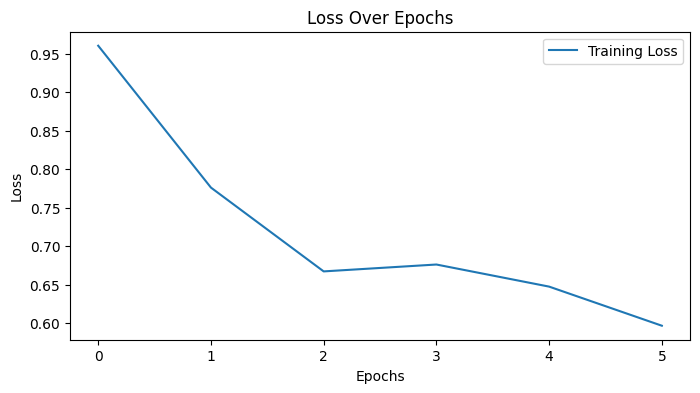

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

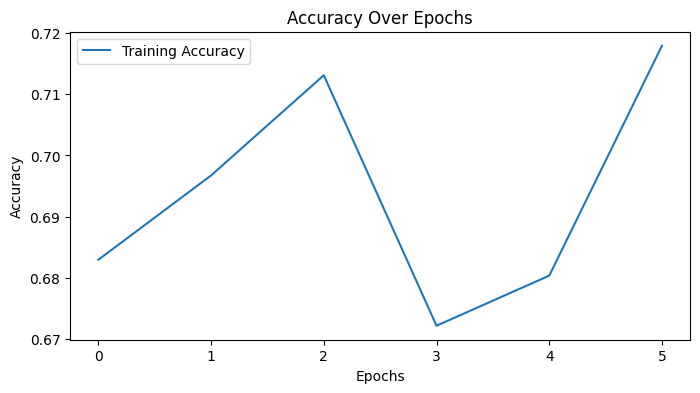

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()